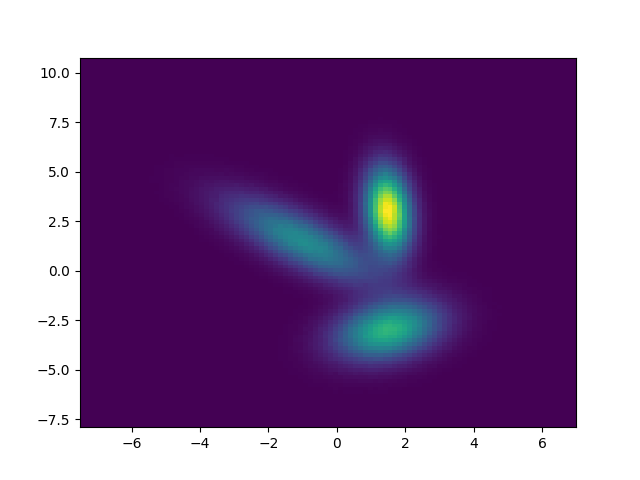

Text(0.5, 1.0, 'Data distribution')

In [63]:
import numpy as np
from matplotlib import pyplot as plt
import torch
%matplotlib widget


data = np.random.randn()

a1 = 1/3
a2 = 1/3
a3 = 1/3

mu1 = np.array([[3],[-6]])/2
mu2 = np.array([[-2],[3]])/2
mu3 = np.array([[3],[6]])/2

sig1 = np.array([[1,0.25],[0.25,1]])
sig2 = np.array([[2,-1.5],[-1.5,2]])
sig3 = np.array([[0.2,-0.1],[-0.1,2]])

L1_sig = np.linalg.cholesky(sig1)
L2_sig = np.linalg.cholesky(sig2)
L3_sig = np.linalg.cholesky(sig3)

samples = 5000000

x1 = mu1 + L1_sig@np.random.randn(2,int(a1*samples))
x2 = mu2 + L2_sig@np.random.randn(2,int(a2*samples))
x3 = mu3 + L3_sig@np.random.randn(2,int(a3*samples))


x_data_samples = np.hstack([x1,x2,x3]).T
x_torch = torch.from_numpy(x_data_samples).unsqueeze(1).type(torch.float)

plt.figure()
plt.hist2d(x_data_samples[:,0],x_data_samples[:,1],bins=100)
plt.show()
plt.title('Data distribution')



In [66]:
x_data_samples.shape

(4999998, 2)

/tmp/ipykernel_1081492/1171405275.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  mu = torch.tensor([mu1,mu2,mu3]).type(torch.float32).permute(2,0,1)


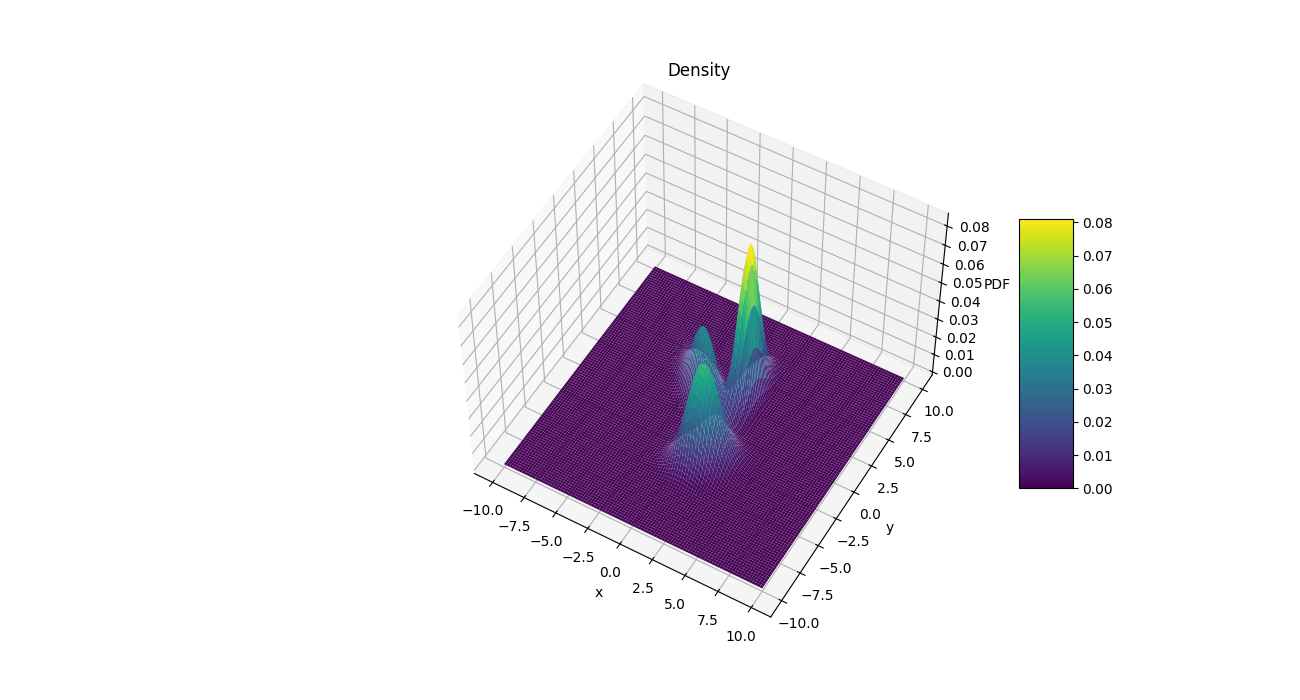

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

res = 100
fact = 1.0
xx,yy = np.meshgrid(np.linspace(-10,10,res),np.linspace(-10,10,res))

positions = torch.tensor(np.vstack([xx.ravel(), yy.ravel()])).type(torch.float32).unsqueeze(0).permute(2,0,1)

a = torch.tensor([a1,a2,a3])
mu = torch.tensor([mu1,mu2,mu3]).type(torch.float32).permute(2,0,1)
sig = torch.tensor([[sig1,sig2,sig3]]).type(torch.float32)*fact

f = lambda x,mu,sig,a: a *1/(2*torch.tensor(np.pi))*torch.det(sig)**(-.5)*torch.exp(-.5*(torch.einsum('ski,ski->sk',(x-mu),torch.einsum('skij,skj->ski',torch.inverse(sig),(x-mu)))))
e = f(positions,mu,sig,a)


grad = lambda x,mu,sig,a: f(x,mu,sig,a).unsqueeze(-1)*torch.einsum('skij,skj->ski',torch.inverse(sig),(x-mu))
vec = -grad(positions,mu,sig,a)

log_grad = lambda x,mu,sig,a: grad(x,mu,sig,a)/(torch.sum(f(x,mu,sig,a),1,keepdim = True).unsqueeze(1)+1e-100)
log_vec = -log_grad(positions,mu,sig,a)

zz = torch.sum(f(positions,mu,sig,a),1).reshape(res,res).numpy()
#zz = torch.log(torch.sum(f(positions,mu,sig,a),1)+1e-100).reshape(res,res).numpy()

fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Density')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(52, -60)
plt.savefig('PDFscores.pdf',bbox_inches='tight')


### Derivative with Respect to $$\mathbf{x}$$

To find the gradient $$\nabla_{\mathbf{x}} p(\mathbf{x})$$, we take the derivative of the log-likelihood and then multiply by $$p(\mathbf{x})$$:

1. **Log-likelihood**:
$$
\log p(\mathbf{x}) = -\frac{d}{2} \log(2\pi) - \frac{1}{2} \log |\Sigma| - \frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu}).
$$

2. **Gradient of the Log-likelihood**:
$$
\nabla_{\mathbf{x}} \log p(\mathbf{x}) = -\Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu}).
$$

3. **Gradient of** p(x):
$$
\nabla_{\mathbf{x}} p(\mathbf{x}) = p(\mathbf{x}) \nabla_{\mathbf{x}} \log p(\mathbf{x}).
$$

Substitute $$\nabla_{\mathbf{x}} \log p(\mathbf{x})$$ into this expression:
$$
\nabla_{\mathbf{x}} p(\mathbf{x}) = p(\mathbf{x}) \left( -\Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right).
$$

### Final Result:
$$
\nabla_{\mathbf{x}} p(\mathbf{x}) = -p(\mathbf{x}) \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu}).
$$

/tmp/ipykernel_1042845/616046249.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M = np.hypot(U, V)


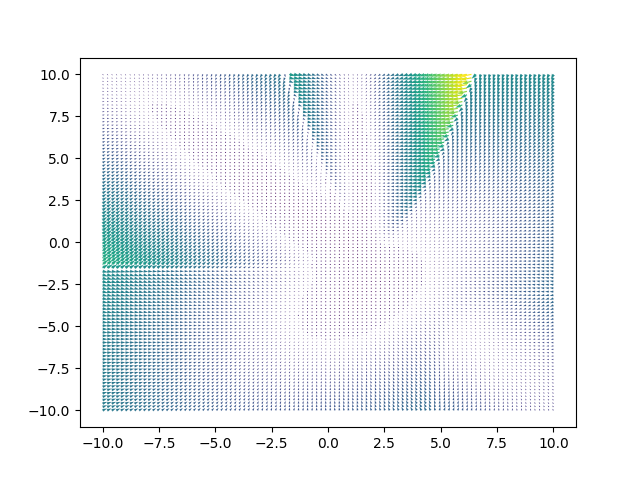

In [8]:
U = torch.sum(log_vec[:,:,0],1,keepdim = True).reshape(res,res)/3
V = torch.sum(log_vec[:,:,1],1,keepdim = True).reshape(res,res)/3
M = np.hypot(U, V)
#Q = ax3.quiver(X, Y, U, V, M, units='x', pivot='tip', width=0.022,scale=1 / 0.15)
plt.figure()
plt.quiver(xx,yy,U,V,M)
plt.show()
plt.title('Score')
plt.savefig('scores.pdf',bbox_inches='tight')

In [5]:
import torch
from torch import nn 

class fc_layer(torch.nn.Module):
    def __init__(self, num_in, num_out):
        
        super(fc_layer, self).__init__()
        
        self.num_in = num_in
        self.num_out = num_out
        
        self.weight = torch.nn.Parameter(torch.empty(num_out, num_in))
        torch.nn.init.normal_(self.weight.data, 0.0, np.sqrt(1/num_out))

    def get_weight(self):

        weight = self.weight

        return weight
    
    def forward(self, x):
        # construct the kernel
        weight = self.get_weight()

        # compute the linear forward
        return torch.nn.functional.linear(x, weight)

    def backward(self, x, output_shape=None):
        # construct the kernel
        weight = self.get_weight()
        
        
        return torch.nn.functional.linear(x,weight.T)

    
class Softplus2(torch.nn.Module):
    def forward(self, x):
        return torch.nn.functional.softplus(x), torch.sigmoid(x)
    
class StudentT_fun2(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.save_for_backward(x)
        ctx.alpha = alpha
        d = 1 + alpha * x ** 2
        return torch.log(d) / (2 * alpha), x / d

    @staticmethod
    def backward(ctx, grad_in1, grad_in2):
        x = ctx.saved_tensors[0]
        d = 1 + ctx.alpha * x ** 2
        return (x / d) * grad_in1 + (1 - ctx.alpha * x ** 2) / d ** 2 * grad_in2, None



class StudentT2(torch.nn.Module):
    def __init__(self, alpha):
        super(StudentT2, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return StudentT_fun2().apply(x, self.alpha)

    
    
class mfc_block(torch.nn.Module):
    
    def __init__(self, config=None):
        super(mfc_block, self).__init__()

        self.num_in = config['num_in']
        self.num_out = config['num_out']
        
        self.fc1 = fc_layer(self.num_in ,self.num_out)
        self.fc2 = fc_layer(self.num_out ,self.num_out)
        self.fc3 = fc_layer(self.num_out ,self.num_out)
        self.fc4 = fc_layer(self.num_out ,self.num_out)
        self.fc5 = fc_layer(self.num_out ,1)
        
        self.act = Softplus2()
        
        
    def forward(self, x):
        
    
        x, self.ap1 = self.act(self.fc1(x))
        x, self.ap2 = self.act(self.fc2(x))
        x, self.ap3 = self.act(self.fc3(x))
        x, self.ap4 = self.act(self.fc4(x))
        x = self.fc5(x)
       
        return x
        
    def backward(self, grad_out):
        
        grad_x = self.fc1.backward(self.fc2.backward(self.fc3.backward(self.fc4.backward(self.fc5.backward(grad_out)*self.ap4)*self.ap3)*self.ap2)*self.ap1)
        
        return grad_x    
    

class grad_net_fc(torch.nn.Module):
    
    def __init__(self, config=None):
        super(grad_net_fc, self).__init__()

        self.num_in = config['num_in']
        self.num_out = config['num_out']

        self.mfc_block = mfc_block(config)
       
    def _activation(self, x):
        
        return torch.sigmoid(x)
        
    def _transformation(self, x):
        
        # extract features
        x = self.mfc_block.forward(x)
    
        return x
        
    def _transformation_T(self, grad_out):
        
        grad_x = self.mfc_block.backward(grad_out)
        
        return grad_x    
    
    def energy(self, x):
        
        return torch.nn.functional.softplus(self._transformation(x))
    
    def grad(self, x):
        
        # forward pass for inner derivative Wx
        x = self._transformation(x) #x = x
        
        # activation sig'(Wx)
        x = self._activation(x)#x = Wx
        
        # times inner derivative sig'(Wx)W.T
        x = self._transformation_T(x) #x = sig'(Wx)
        
        return x
    
class BasicScoreNet(nn.Module):
    def __init__(self):
        super(BasicScoreNet, self).__init__()

        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        #self.fc3 = nn.Linear(64, 64)
        #self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(128, 1)
       
        
    def forward(self, x):
        
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        #x = F.leaky_relu(self.fc3(x))
        #x = F.leaky_relu(self.fc4(x))
        x = self.fc5(x)
        return x
    

In [6]:
from torch import nn
from torch.nn import functional as F
import numpy as np

    
res = 1000

xx,yy = np.meshgrid(np.linspace(-8,8,res),np.linspace(-8,8,res))
positions = torch.tensor(np.vstack([xx.ravel(), yy.ravel()])).type(torch.float32).unsqueeze(0).permute(2,0,1)
vec = -log_grad(positions,mu,sig,a)
y = torch.sum(vec,1).cuda()

config = {
    'num_out': 64,
    'num_in': 2,
}

scnet = grad_net_fc(config).cuda()
optimizer = torch.optim.AdamW(scnet.parameters(),1e-3,(.9,.999),weight_decay=1e-2)


for i in range(4000):
    
    x = scnet.grad(positions[:,0,:].cuda())
    
    L = torch.mean((x-y)**2)+1e-3*torch.mean(scnet.energy(positions[:,0,:].cuda())**2)
    
    if i %100 == 0: print(L.item())
    
    L.backward()
    optimizer.step()
    optimizer.zero_grad()

        

18.42987060546875
6.811279773712158


KeyboardInterrupt: 

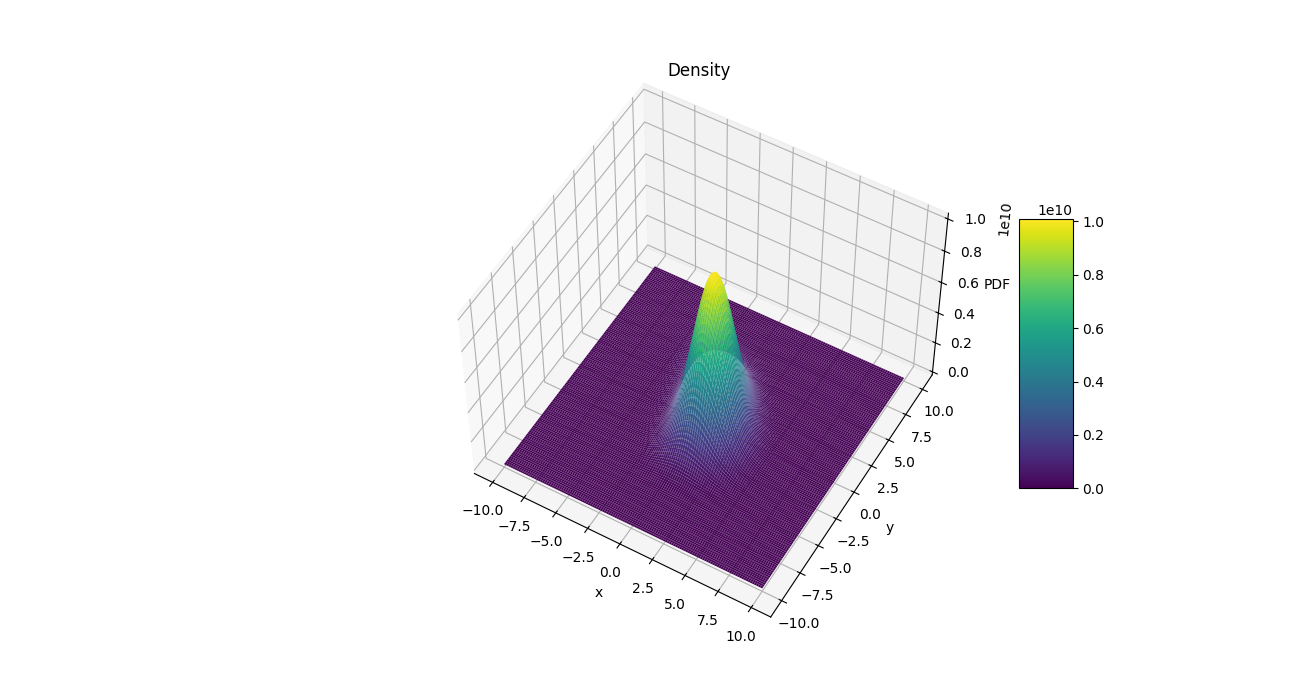

In [7]:
# pLOT lEARNED dENSITY
res = 128
xx,yy = np.meshgrid(np.linspace(-10,10,res),np.linspace(-10,10,res))
positions = torch.tensor(np.vstack([xx.ravel(), yy.ravel()])).type(torch.float32).unsqueeze(0).permute(2,0,1)
Temp = 2
zz = np.exp(scnet.energy(positions.cuda()).reshape(res,res).detach().cpu().numpy()/Temp)
#zz/= np.max(zz)
#zz = np.exp(zz)

fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Density')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(52, -60)
plt.savefig('PDFscores_learned.pdf',bbox_inches='tight')

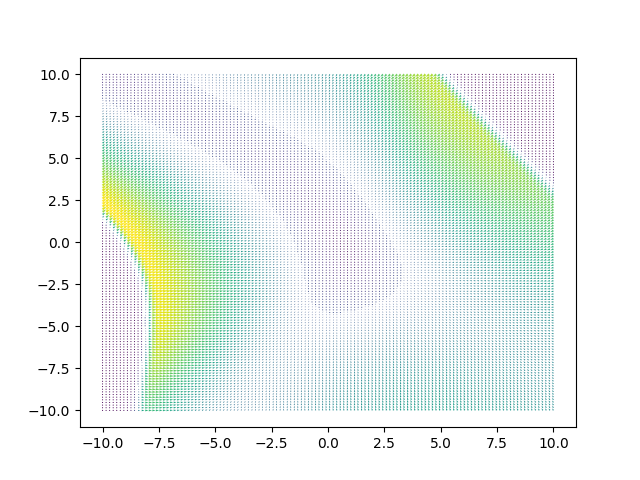

In [8]:
# use learned scores to plot the vector field
score = scnet.grad(positions[:,0,:].cuda())
U = score[:,0].reshape(res,res).detach().cpu().numpy()
V = score[:,1].reshape(res,res).detach().cpu().numpy()
M = np.hypot(U, V)
plt.figure()
plt.quiver(xx,yy,U,V,M)
plt.show()

# No Access to data density function
If we do not have access to the density function of the data (which is basically always the case), but we can sample datapoint we can still learn the score.
Score Matching:
$$
p(\mathbf{x}_i \mid \mathbf{x}_{i-1}) = \mathcal{N}(\mathbf{x}_i; \sqrt{1 - \beta_i} \mathbf{x}_{i-1}, \beta_i \mathbf{I})
$$
then
$$
p_{\alpha_i}(\mathbf{x}_i \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_i; \sqrt{\alpha_i} \mathbf{x}_0, (1 - \alpha_i) \mathbf{I}) \hspace{0.5cm} with \hspace{0.5cm} \alpha_i := \prod_{j=1}^{i} (1 - \beta_j)
$$

**Algorithm 1 Training**

1. **repeat**
2.    $\mathbf{x}_0 \sim q(\mathbf{x}_0)$
3.    $t \sim \text{Uniform}(\{1, \ldots, T\})$
4.    $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
5.    Take gradient descent step on 
      $
      \nabla_{\boldsymbol{\theta}} \left\| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}}\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}, t\right) \right\|^2
      $
6. **until** converged


In [273]:
class DataDistribution:
    def __init__(self, config):
        self.mu = []
        self.sig = []
        self.L_sig = []
        self.generator = np.random.RandomState(0)
        # get mus from config
        for i in range(len(config['gaussians'])):
            self.mu.append(np.array(config['gaussians'][i]['mu']))
            self.sig.append(np.array(config['gaussians'][i]['cov']))
            self.L_sig.append(np.linalg.cholesky(self.sig[i]))
        self.mu = np.array(self.mu)
        self.sig = np.array(self.sig)
        self.L_sig = np.array(self.L_sig)

    def __call__(self, n_samples=1):
        # sample which gaussian to sample from use random state
        idx = np.random.choice(len(self.mu), n_samples)
        # sample from the chosen gaussian
        
        return self.mu[idx][...,0] + np.einsum("nij, nj->ni", self.L_sig[idx], np.random.randn(n_samples, 2)) #self.L_sig[idx]@np.random.randn(2, n_samples).T)
    
    def sample(self, n_samples=1):
        return self(n_samples)

config = {
'gaussians': [
    {'mu': [[3],[-6]], 'cov': [[1,0.25],[0.25,1]]},
    {'mu': [[-2],[3]], 'cov': [[2,-1.5],[-1.5,2]]},
    {'mu': [[3],[6]], 'cov': [[0.2,-0.1],[-0.1,2]]}
]}

data_dist = DataDistribution(config)

# config for 8 gaussians in a circle
r  = 5
config_circle = {
'gaussians': [
    {'mu': [[r*np.cos(2*np.pi*i/8)],[r*np.sin(2*np.pi*i/8)]], 'cov': [[0.5,0],[0,0.5]]} for i in range(8)
]}

gaussian_circle = DataDistribution(config_circle)

# define forward process and degrade data with forward process and noise
class BasicForwardModel:
    def __init__(self, data_distribution, config):
        self.data_dist = data_distribution
        # identity matrix
        self.A = np.array([[1,0],[0,1]])
        # noise level
        self.mu = np.array(config['mu'])
        self.sig = np.array(config['cov'])
        self.L_sig = np.linalg.cholesky(np.diag(self.sig))
    
    def __call__(self, n_samples=1):
        # forward process
        x = self.data_dist(n_samples)
        # forward operator
        y = x@self.A.T
        # add noise
        
        y += (self.L_sig@np.random.randn(2, n_samples)).T + self.mu[None]
        return y

    def set_A(self, A):
        self.A = A


from sklearn.datasets import make_moons
class MoonDataset:
    def __init__(noise=0.05):
        self.noise = noise

    def __call__(self, n_samples=1):
        x = make_moons(n_samples, noise=self.noise)[0]
        x = torch.tensor(x).type(torch.float32)
        return x
    
    def sample(self, n_samples=1):
        return self(n_samples)

[[ 1.07470257 -1.2300731 ]
 [ 1.23623759 -0.42158495]
 [-4.68743186 -0.08013741]
 ...
 [-3.71760729  0.02177253]
 [-2.36628301  0.73440417]
 [-0.03096816 -0.49593791]]


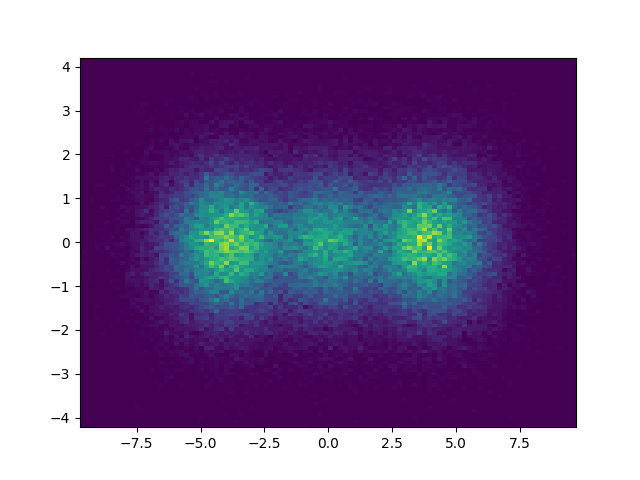

In [276]:
# plot gaussian circle distribution
measurement_model = BasicForwardModel(gaussian_circle, {'mu': [0,0], 'cov': [1,1]})
measurement_model.set_A(np.array([[1,0],[0,0]]))
n_samples = 100000
x = measurement_model(n_samples)
print(x)
plt.figure()
plt.hist2d(x[:,0],x[:,1],bins=100)
plt.show()

In [84]:
# define score matching network
from torch import nn
from torch.nn import functional as F
class BasicScoreNet(nn.Module):
    def __init__(self, hidden_size=128):
        super(BasicScoreNet, self).__init__()
        self.fc1 = nn.Linear(3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, 2)
       
        
    def forward(self, x):
        
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = self.fc6(x)
        return x

    def sample(self, t, x):
        t = torch.ones(x.shape[0],1, device=x.device).type(torch.float32)*t
        x = torch.cat([x, t],1)
        return self.forward(x)

# DDPM  

## Training

In [187]:
# DDPM / VP score matching
beta_min = 1e-4
beta_max = 0.02
num_steps = 1000
betas = torch.linspace(beta_min,beta_max,num_steps).cuda()
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
training_iterations = 10000

batch_size = 500
denoiser = BasicScoreNet(hidden_size=256).cuda()
optimizer = torch.optim.AdamW(denoiser.parameters(),1e-4,(.9,.999),weight_decay=1e-2)
data = gaussian_circle
for i in range(training_iterations):
    # sample timestep
    t = torch.randint(0,num_steps,(batch_size,)).cuda()
    alpha_cumprod_t = alpha_cumprod[t]
    # sample datapoint
    x = torch.tensor(data.sample(batch_size)).type(torch.float32).cuda()
    # sample noise
    eps = torch.randn(batch_size,2).cuda()
    # noise sample
    x_t = alpha_cumprod_t[:,None] * x + eps * (1-alpha_cumprod_t[:,None])
    # compute scores
    eps_pred = denoiser(torch.cat([x_t, t[:,None]/1000], 1))
    # compute loss
    loss = torch.mean((eps_pred - eps)**2)
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0: print(loss.item())

print('done')
print(f"loss: {loss.item()}")


0.992250919342041
0.5317023396492004
0.46475300192832947
0.41021859645843506
0.3802529573440552
0.3310684859752655
0.3927990198135376
0.34595823287963867
0.3713817894458771
0.3778902292251587
0.37572604417800903
0.3625445067882538
0.35811328887939453
0.39928773045539856
0.3494383692741394
0.28723475337028503
0.33847084641456604
0.32556623220443726
0.3876808285713196
0.30637025833129883
0.2984386086463928
0.3363078534603119
0.3178461492061615
0.2953222393989563
0.33925729990005493
0.3451840877532959
0.33973971009254456
0.3506918251514435
0.343900591135025
0.34842121601104736
0.2681118845939636
0.31671497225761414
0.3192349970340729
0.35942956805229187
0.346854567527771
0.3346019685268402
0.36274731159210205
0.3797342777252197
0.2979210615158081
0.34029287099838257
0.3805835545063019
0.3324134051799774
0.35848674178123474
0.38092145323753357
0.3724050521850586
0.3593403100967407
0.36969494819641113
0.35337793827056885
0.34713876247406006
0.30968034267425537
0.2947927713394165
0.301427036

## plot sampled density

In [188]:
from PIL import Image
import cv2
# sample from gaussian
n_samples = 100000
# map to learned distribution
n_steps = 1000
x_t = torch.randn(n_samples,2).cuda()
frame_size = (546, 435)  # Adjust based on your saved image dimensions
fps = 30  # Frames per second
out = cv2.VideoWriter('x_t_distribution.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)


with torch.no_grad():
    for t in range(n_steps-1,-1,-1):
        alpha_cumprod_t = alpha_cumprod[t]
        alpha_t = alpha[t]
        sigma_t = betas[t]**0.5
        eps_pred = denoiser(torch.cat([x_t, torch.ones(n_samples,1).cuda()*t/1000], 1))
        x_t = 1/alpha_t**0.5 * (x_t - (1-alpha_t)/ (1-alpha_cumprod_t)**0.5 * eps_pred) + sigma_t * torch.randn(n_samples,2).cuda()
        # plot x_t
        # save plots as video
        if t % 10 == 0:
            plt.figure()
            plt.hist2d(x_t[:,0].detach().cpu().numpy(),x_t[:,1].detach().cpu().numpy(),bins=100)
            plt.title(f'Learned density at t={t}')
            plt.savefig(f'./ddpm_density_learned/learned_density_{t}.png',bbox_inches='tight')
            frame = cv2.imread(f'./ddpm_density_learned/learned_density_{t}.png')
            frame = cv2.resize(frame, frame_size)  # Resize to match video frame size
            out.write(frame)
            

            plt.close()

# plot last iteration 
plt.figure()
plt.hist2d(x_t[:,0].detach().cpu().numpy(),x_t[:,1].detach().cpu().numpy(),bins=100)
plt.title(f'Learned density at t={t}')
plt.savefig(f'./ddpm_density_learned/learned_density_{t}.png',bbox_inches='tight')
frame = cv2.imread(f'./ddpm_density_learned/learned_density_{t}.png')
frame = cv2.resize(frame, frame_size)  # Resize to match video frame size
out.write(frame)
out.release()
plt.close()

## Trajectory of single data points

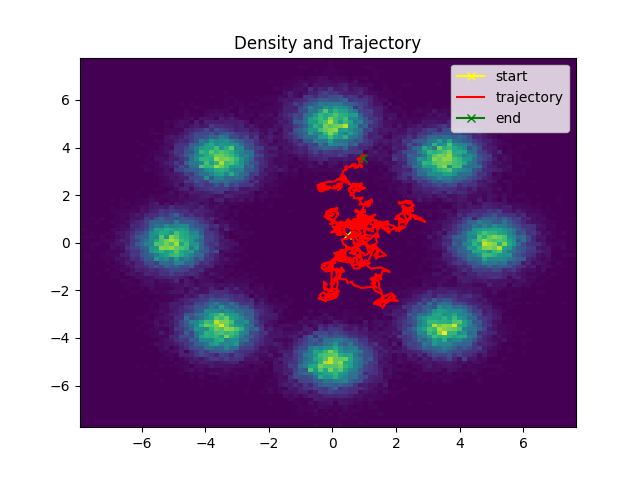

In [189]:
# simluate trajectory of single data points
n_steps = 1000
x_init = torch.randn(1,2).cuda()
x_t = x_init
# save trajectory
traj = []
with torch.no_grad():
    for t in range(n_steps-1,-1,-1):
        alpha_cumprod_t = alpha_cumprod[t]
        alpha_t = alpha[t]
        sigma_t = betas[t]**0.5
        eps_pred = denoiser(torch.cat([x_t, torch.ones(1,1).cuda()*t/1000], 1))
        x_t = 1/alpha_t**0.5 * (x_t - (1-alpha_t)/ (1-alpha_cumprod_t)**0.5 * eps_pred) + sigma_t * torch.randn(1,2).cuda()
        traj.append(x_t.detach().cpu().numpy())

# draw trajectory on density plot
plt.figure()
# name plot
plt.title('Density and Trajectory')
# plot density
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)

plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# add legend
plt.legend(['start','trajectory','end'])



# DDIM
Accelerated formulation. $\alpha_t$ is equivalent to the  cumulative product of $\alpha_t$ in DDPM
$$

\frac{x_{t-\Delta t}}{\sqrt{\alpha_{t-\Delta t}}} = \frac{x_t}{\sqrt{\alpha_t}} + \left( \sqrt{\frac{1 - \alpha_{t-\Delta t}}{\alpha_{t-\Delta t}}} - \sqrt{\frac{1 - \alpha_t}{\alpha_t}} \right) \epsilon_\theta^{(t)}(x_t)

$$

## Density of DDIM Model


In [199]:
# DDIM sampling settings
n_ddim_steps = 100
n_steps = 1000
skip = int(n_steps/n_ddim_steps)
timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
eta = 0.0

n_samples = 100000
x_t = torch.randn(n_samples,2).cuda()
frame_size = (546, 435)  # Adjust based on your saved image dimensions
fps = 30  # Frames per second
out = cv2.VideoWriter('x_t_distribution_DDIM.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)
with torch.no_grad():
    for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
        a_t = alpha_cumprod[t]
        a_t_next = alpha_cumprod[t_next]

        eps_pred = denoiser(torch.cat([x_t, torch.ones(n_samples,1).cuda()*t/1000], 1))
        # ddim step
        x0_t = (x_t - eps_pred * (1-a_t)**0.5) / a_t**0.5
        c1 = eta * ((1-a_t/a_t_next)* (1-a_t_next)/(1-a_t))**0.5
        c2 = ((1-a_t_next) - c1 **2)**0.5
        x_t = a_t_next**0.5 *x0_t + c1 * torch.randn_like(x_t) + c2 * eps_pred
        # plot x_t
        # save plots as video
        if t % 1 == 0:
            plt.figure()
            plt.hist2d(x_t[:,0].detach().cpu().numpy(),x_t[:,1].detach().cpu().numpy(),bins=100)
            plt.title(f'DDIM density at t={t}')
            plt.savefig(f'./ddim_density/learned_density_{t}.png',bbox_inches='tight')
            frame = cv2.imread(f'./ddim_density/learned_density_{t}.png')
            frame = cv2.resize(frame, frame_size)
            out.write(frame)
            plt.close()


# plot last iteration
plt.figure()
plt.hist2d(x_t[:,0].detach().cpu().numpy(),x_t[:,1].detach().cpu().numpy(),bins=100)
plt.title(f'DDIM density at t={t}')
plt.savefig(f'./ddim_density/learned_density_{t}.png',bbox_inches='tight')
plt.close()
frame = cv2.imread(f'./ddim_density/learned_density_{t}.png')
frame = cv2.resize(frame, frame_size)
out.write(frame)
out.release()




No such comm: d5dbfff57c9f459b8eb4c7db233ed3e2


## Trajectory of single datapoint

start point tensor([[3.4687e-01, 3.1669e-04]], device='cuda:0')
tensor(0.0010, device='cuda:0') tensor(0.0100, device='cuda:0') tensor(4.0358e-05, device='cuda:0')


Text(0.5, 1.0, 'Density and Trajectory DDIM eta=0.1')

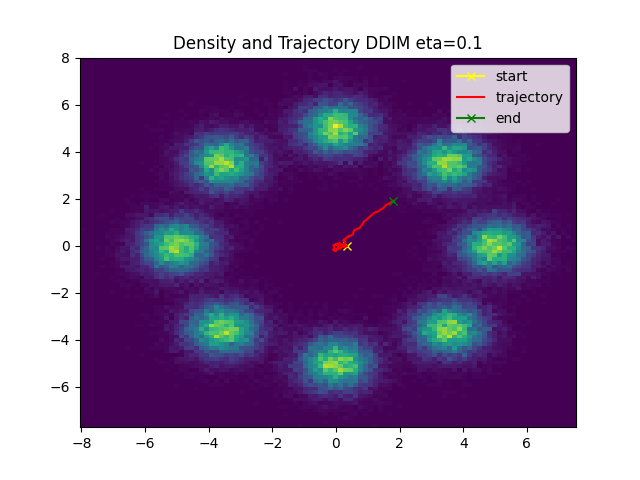

In [239]:
x_t = x_init
print("start point", x_t)
eta = 0.1
# save trajectory
traj = [x_t.detach().cpu().numpy()]
with torch.no_grad():
    for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
        a_t = alpha_cumprod[t]
        a_t_next = alpha_cumprod[t_next]

        eps_pred = denoiser(torch.cat([x_t, torch.ones(1,1).cuda()*t/1000], 1))
        # ddim step
        x0_t = (x_t - eps_pred * (1-a_t)**0.5) / a_t**0.5
        c1 = eta * ((1-a_t/a_t_next)* (1-a_t_next)/(1-a_t))**0.5
        c2 = ((1-a_t_next) - c1 **2)**0.5
        x_t = a_t_next**0.5 *x0_t + c1 * torch.randn_like(x_t) + c2 * eps_pred
        traj.append(x_t.detach().cpu().numpy())
print(c1, c2, alpha_cumprod[t-skip])
# draw trajectory on density plot
plt.figure()
# name plot
plt.title('Density and Trajectory')
# plot density
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)

plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# add legend
plt.legend(['start','trajectory','end'])
# name
plt.title(f'Density and Trajectory DDIM eta={eta}')




# Flow Matching / Rectified Flow
Loss:
$$ \arg\min_\theta \mathbb{E}_{t, q(x_1), p(x_0)} \| v_t(\phi_t(x_0); \theta) - (x_1 - x_0) \|^2,
$$

## Training

In [348]:
# Flow Matching
training_iterations = 10000

batch_size = 500
denoiser_flow = BasicScoreNet(hidden_size=256).cuda()
optimizer = torch.optim.AdamW(denoiser_flow.parameters(),1e-3,(.9,.999),weight_decay=1e-2)
sig_min = 1e-4
data = gaussian_circle
for i in range(training_iterations):
    # sample timestep
    t = torch.rand((batch_size,)).cuda()[:,None] 
    # sample datapoint
    x1 = torch.tensor(data.sample(batch_size)).type(torch.float32).cuda()
    # sample noise
    x0 = torch.randn(batch_size,2).cuda()
    # interpolate between samples

    x_t = (sig_min+(1-sig_min)*t)*x1 + (1-t)*x0
    # compute drift v
    v = denoiser_flow(torch.cat([x_t, t], 1))
    # compute loss
    loss = torch.mean((v - (x1 - x0*(1-sig_min)))**2)
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0: print(loss.item())

print('done')
print(f"loss: {loss.item()}")


13.957001686096191
6.301362037658691
5.267725944519043
4.806150436401367
4.717128276824951
5.483012676239014
5.3650665283203125
5.396908283233643
5.4633283615112305
5.27172327041626
5.089700222015381
4.61853551864624
5.793609619140625
4.472192287445068
5.207597732543945
5.210249900817871
5.087306499481201
5.380680084228516
4.756515979766846
5.13366174697876
5.189189434051514
5.733798027038574
5.653936862945557
5.480201721191406
4.894617557525635
5.178355693817139
4.812386989593506
5.144894599914551
5.197659492492676
5.199156284332275
5.415955543518066
4.950141906738281
5.083602428436279
4.922080039978027
5.599788188934326
4.977075576782227
5.023588180541992
5.011847019195557
5.669057369232178
5.3807268142700195
5.525701522827148
5.095282554626465
5.313097953796387
5.2190070152282715
5.264413833618164
5.169937610626221
4.850152015686035
5.229236602783203
5.04576301574707
5.731599807739258
5.340620517730713
5.004990577697754
5.249882221221924
4.754752159118652
5.416072845458984
5.5426740

## Flow Matching Sampling


In [349]:
#Flow matching reverse ODE
from torchdiffeq import odeint
import cv2

num_steps = 10
n_samples = 100000
x_t = torch.randn(n_samples,2).cuda()

frame_size = (546, 435)  # Adjust based on your saved image dimensions
fps = 30  # Frames per second density video
out = cv2.VideoWriter('x_t_flow_matching_distribution.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)

timesteps = np.linspace(0, 1, num_steps)
with torch.no_grad():
    for i, (t_prev, t_curr) in enumerate(zip(timesteps[:-1], timesteps[1:])):
        v_pred = denoiser_flow(torch.cat([x_t, torch.ones(n_samples,1).cuda()*t_curr], 1))
        dt = t_curr - t_prev
        x_t = x_t + dt * v_pred
        # plot x_t
        if i % 1 == 0:
            plt.figure()
            plt.hist2d(x_t[:,0].detach().cpu().numpy(),x_t[:,1].detach().cpu().numpy(),bins=100)
            plt.title(f'Learned density at t={t_curr}')
            plt.savefig(f'./flow_matching_density_learned/learned_density_{i}.png',bbox_inches='tight')
            frame = cv2.imread(f'./flow_matching_density_learned/learned_density_{i}.png')
            frame = cv2.resize(frame, frame_size)  # Resize to match video frame size
            out.write(frame)
            plt.close()
    # x_t = torch.randn(n_samples,2).cuda()
    # traj = odeint(denoiser_flow.sample, x_t,torch.linspace(1, 0., num_steps, device='cpu').to("cuda"),rtol=1e-4,atol=1e-4)

# plot last iteration
plt.figure()
plt.hist2d(x_t[:,0].detach().cpu().numpy(),x_t[:,1].detach().cpu().numpy(),bins=100)
plt.title(f'Learned density at t={t_curr}')
plt.savefig(f'./flow_matching_density_learned/learned_density_{i}.png',bbox_inches='tight')
frame = cv2.imread(f'./flow_matching_density_learned/learned_density_{i}.png')
frame = cv2.resize(frame, frame_size)  # Resize to match video frame size
out.write(frame)
out.release()
plt.close()


## Trajectory of single data point

start point tensor([[3.4687e-01, 3.1669e-04]], device='cuda:0', requires_grad=True)


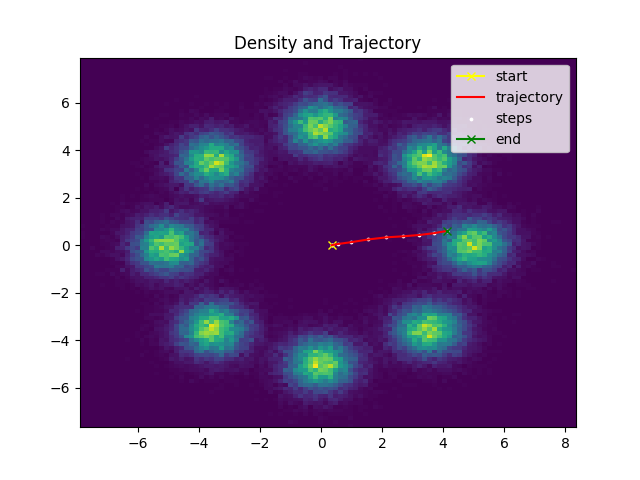

In [350]:
# Flow matching trajectory
n_steps = 10 
x_t = x_init
print("start point", x_t)
timesteps = np.linspace(0, 1, n_steps)

# save trajectory
traj = [x_t.detach().cpu().numpy()]
with torch.no_grad():
    for i, (t_prev, t_curr) in enumerate(zip(timesteps[:-1], timesteps[1:])):
        v_pred = denoiser_flow(torch.cat([x_t, torch.ones(1,1).cuda()*t_curr], 1))
        dt = t_curr - t_prev
        x_t = x_t + dt * v_pred
        traj.append(x_t.detach().cpu().numpy())
# draw trajectory on density plot
plt.figure()
# name plot
plt.title('Density and Trajectory')
# plot density
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)
plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
# plot white dot at every point in traj
plt.scatter(traj[:,0,0],traj[:,0,1], color='white', s=3)
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# add legend
plt.legend(['start','trajectory','steps','end'])

# Conditional Sampling

## Introduce Measurment Model and use test time guidance to guide diffusion process towards posterior


## DDIM Test Time Guidance

start point tensor([[3.4687e-01, 3.1669e-04]], device='cuda:0', requires_grad=True)
tensor(24.6495, device='cuda:0', grad_fn=<SumBackward0>) tensor([[1.6637, 9.7893]], device='cuda:0')
tensor(24.5518, device='cuda:0', grad_fn=<SumBackward0>) tensor([[1.6587, 9.7702]], device='cuda:0')
tensor(24.4546, device='cuda:0', grad_fn=<SumBackward0>) tensor([[1.6537, 9.7511]], device='cuda:0')
tensor(24.3578, device='cuda:0', grad_fn=<SumBackward0>) tensor([[1.6487, 9.7320]], device='cuda:0')
tensor(24.2613, device='cuda:0', grad_fn=<SumBackward0>) tensor([[1.6438, 9.7130]], device='cuda:0')
tensor(24.1652, device='cuda:0', grad_fn=<SumBackward0>) tensor([[1.6389, 9.6941]], device='cuda:0')
tensor(24.0695, device='cuda:0', grad_fn=<SumBackward0>) tensor([[1.6340, 9.6751]], device='cuda:0')
tensor(23.9742, device='cuda:0', grad_fn=<SumBackward0>) tensor([[1.6291, 9.6562]], device='cuda:0')
tensor(23.8792, device='cuda:0', grad_fn=<SumBackward0>) tensor([[1.6242, 9.6374]], device='cuda:0')
tensor(

Text(0.5, 1.0, 'Density and Trajectory DDIM eta=0.0')

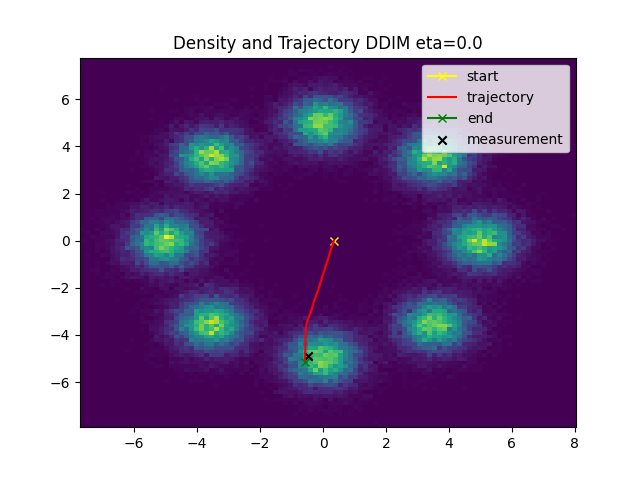

In [400]:
x_t = x_init
n_ddim_steps = 1000
n_steps = 1000
skip = int(n_steps/n_ddim_steps)
print("start point", x_t)
# generate measurement y
measurement_model = BasicForwardModel(data, {'mu': [0,0], 'cov': [0.2,0.2]})
# measurement_model = BasicForwardModel(gaussian_circle, {'mu': [0,0], 'cov': [1,1]})
# measurement_model.set_A(np.array([[1,0],[0,0]]))
y = torch.Tensor(measurement_model(1)).cuda()
eta = 0.
lr = 0.001
timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1

# save trajectory
traj = [x_t.detach().cpu().numpy()]
for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
    with torch.no_grad():
        a_t = alpha_cumprod[t]
        a_t_next = alpha_cumprod[t_next]
        
        eps_pred = denoiser(torch.cat([x_t, torch.ones(1,1).cuda()*t/1000], 1))
        # ddim step
        x0_t = (x_t - eps_pred * (1-a_t)**0.5) / a_t**0.5
        c1 = eta * ((1-a_t/a_t_next)* (1-a_t_next)/(1-a_t))**0.5
        c2 = ((1-a_t_next) - c1 **2)**0.5
        x_t = a_t_next**0.5 *x0_t + c1 * torch.randn_like(x_t) + c2 * eps_pred
        with torch.enable_grad():
            x_t.requires_grad_()
            y_generated = (torch.Tensor(measurement_model.A).cuda() @ x_t.T).T
            loss = torch.sum((y_generated - y)**2)
            loss.backward()
            gradients = x_t.grad
            print(loss, gradients)
        # data term
        x_t = x_t - lr * gradients

        traj.append(x_t.detach().cpu().numpy())
# draw trajectory on density plot
plt.figure()
# name plot
plt.title('Density and Trajectory')
# plot density
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)

plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# plot meaasurement y
plt.scatter(y[0,0].detach().cpu().numpy(),y[0,1].detach().cpu().numpy(), color='black', marker='x')
# add legend
plt.legend(['start','trajectory','end', 'measurement'])
# name
plt.title(f'Density and Trajectory DDIM eta={eta}')




start point tensor([[ 1.3908, -0.2885]], device='cuda:0')
tensor(12.3668, device='cuda:0', grad_fn=<MeanBackward0>) tensor([[1.8766, 4.6056]], device='cuda:0')
tensor(10.0246, device='cuda:0', grad_fn=<MeanBackward0>) tensor([[1.6744, 4.1528]], device='cuda:0')
tensor(8.1354, device='cuda:0', grad_fn=<MeanBackward0>) tensor([[1.4950, 3.7464]], device='cuda:0')
tensor(6.6078, device='cuda:0', grad_fn=<MeanBackward0>) tensor([[1.3374, 3.3804]], device='cuda:0')
tensor(5.3644, device='cuda:0', grad_fn=<MeanBackward0>) tensor([[1.1988, 3.0482]], device='cuda:0')
tensor(4.3504, device='cuda:0', grad_fn=<MeanBackward0>) tensor([[1.0763, 2.7463]], device='cuda:0')
tensor(3.5237, device='cuda:0', grad_fn=<MeanBackward0>) tensor([[0.9679, 2.4720]], device='cuda:0')
tensor(2.8510, device='cuda:0', grad_fn=<MeanBackward0>) tensor([[0.8708, 2.2234]], device='cuda:0')
tensor(2.3031, device='cuda:0', grad_fn=<MeanBackward0>) tensor([[0.7837, 1.9980]], device='cuda:0')
tensor(1.8545, device='cuda:0',

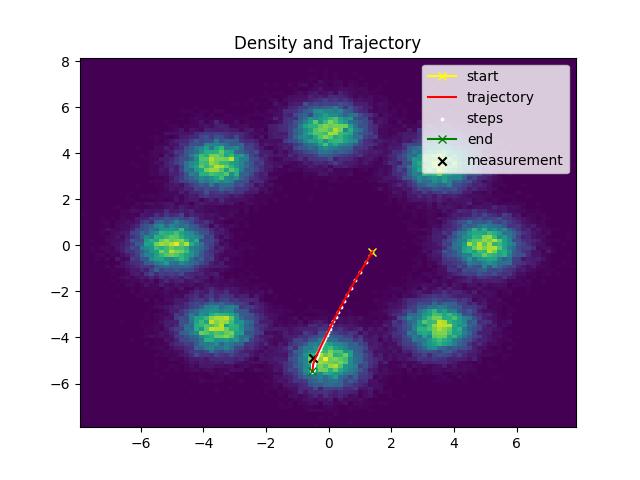

In [451]:
# Flow Matching normal Sampling

n_steps = 100

# save trajectory
lr = 0.1
x_t = x_init
x_t = torch.randn(1,2).cuda()
print("start point", x_t)
timesteps = np.linspace(0, 1, n_steps)

# save trajectory
traj = [x_t.detach().cpu().numpy()]
with torch.no_grad():
    for i, (t_prev, t_curr) in enumerate(zip(timesteps[:-1], timesteps[1:])):
        v_pred = denoiser_flow(torch.cat([x_t, torch.ones(1,1).cuda()*t_curr], 1))
        dt = t_curr - t_prev
        with torch.enable_grad():
            x_t.requires_grad_()
            y_generated = (torch.Tensor(measurement_model.A).cuda() @ x_t.T).T
            loss = torch.mean((y_generated - y)**2)
            loss.backward()
            gradients = x_t.grad
        x_t = x_t + dt * v_pred - gradients * lr
        
        
        traj.append(x_t.detach().cpu().numpy())
# draw trajectory on density plot
plt.figure()
# name plot
plt.title('Density and Trajectory')
# plot density
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)
plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
# plot white dot at every point in traj
plt.scatter(traj[:,0,0],traj[:,0,1], color='white', s=3)
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# plot measurement y
plt.scatter(y[0,0].detach().cpu().numpy(),y[0,1].detach().cpu().numpy(), color='black', marker='x')
# add legend
plt.legend(['start','trajectory','steps','end', 'measurement'])

0.98989898989899
0.9797979797979798
0.9696969696969697
0.9595959595959596
0.9494949494949495
0.9393939393939394
0.9292929292929293
0.9191919191919192
0.9090909090909091
0.898989898989899
0.8888888888888888
0.8787878787878788
0.8686868686868687
0.8585858585858586
0.8484848484848485
0.8383838383838383
0.8282828282828283
0.8181818181818181
0.8080808080808081
0.797979797979798
0.7878787878787878
0.7777777777777778
0.7676767676767676
0.7575757575757576
0.7474747474747474
0.7373737373737373
0.7272727272727273
0.7171717171717171
0.7070707070707071
0.696969696969697
0.6868686868686869
0.6767676767676767
0.6666666666666666
0.6565656565656566
0.6464646464646464
0.6363636363636364
0.6262626262626263
0.6161616161616161
0.606060606060606
0.5959595959595959
0.5858585858585859
0.5757575757575757
0.5656565656565656
0.5555555555555556
0.5454545454545454
0.5353535353535352
0.5252525252525252
0.5151515151515151
0.505050505050505
0.4949494949494949
0.48484848484848475
0.4747474747474747
0.4646464646464646

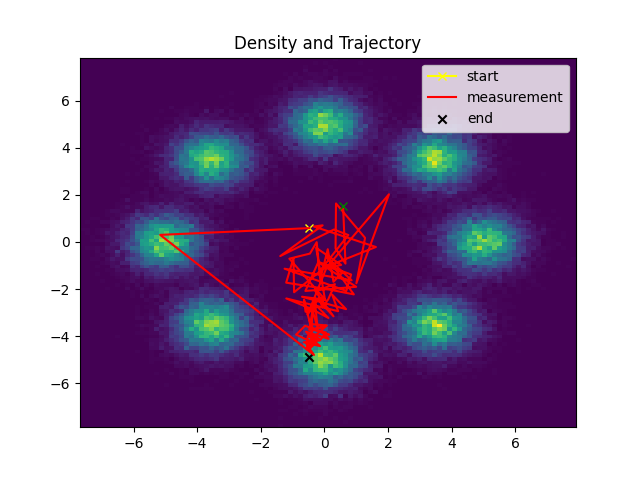

In [450]:
# Variational Sampling
x_mu = torch.Tensor(measurement_model(1)).cuda()
n_steps = 100
timesteps = np.linspace(0, 1, n_steps)

# save trajectory
traj = [x_t.detach().cpu().numpy()]
n_datasteps = 10
lr = 0.1
for i, (t_prev, t_curr) in enumerate(zip(timesteps[:-1], timesteps[1:])):
    with torch.no_grad():
        # sample timestep
        t = torch.rand((1,1)).cuda()
        # noise observation
        t = t_curr
        # for _ in range(n_datasteps):
        with torch.enable_grad():
            x_mu.requires_grad_()
            y_generated = (torch.Tensor(measurement_model.A).cuda() @ x_mu.T).T
            loss = torch.mean((y_generated - y)**2)
            loss.backward()
            gradients = x_mu.grad
            # x_mu = x_mu - lr * gradients
        x_0 = torch.randn_like(x_mu)
        x_t = (1-t)*x_mu + t*x_0
        v_pred = denoiser_flow(torch.cat([x_t, torch.ones(1,1).cuda()*t_curr], 1))
        x_0_pred = x_mu + v_pred * (1-t)
        print(1-t)
        reg_step = x_mu - x_0_pred
        x_mu = x_mu - lr * reg_step - 1 * gradients
        traj.append(x_t.detach().cpu().numpy())
# draw trajectory on density plot
plt.figure()
# name plot
plt.title('Density and Trajectory')
# plot density
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)
plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
# plot white dot at every point in traj
# plt.scatter(traj[:,0,0],traj[:,0,1], color='white', s=3)
# plot measurement y
plt.scatter(y[0,0].detach().cpu().numpy(),y[0,1].detach().cpu().numpy(), color='black', marker='x')
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# add legend
plt.legend(['start','measurement','end'])